Files already downloaded and verified
Files already downloaded and verified
Epoch [1/20], Loss: 0.0128, val_loss: 0.0079, val_acc: 0.8305
Epoch [2/20], Loss: 0.0069, val_loss: 0.0089, val_acc: 0.8129
Epoch [3/20], Loss: 0.0051, val_loss: 0.0070, val_acc: 0.8574
Epoch [4/20], Loss: 0.0038, val_loss: 0.0091, val_acc: 0.8252
Epoch [5/20], Loss: 0.0029, val_loss: 0.0074, val_acc: 0.8571
Epoch [6/20], Loss: 0.0026, val_loss: 0.0066, val_acc: 0.8764
Epoch [7/20], Loss: 0.0022, val_loss: 0.0071, val_acc: 0.8706
Epoch [8/20], Loss: 0.0019, val_loss: 0.0070, val_acc: 0.8750
Epoch [9/20], Loss: 0.0017, val_loss: 0.0074, val_acc: 0.8738
Epoch [10/20], Loss: 0.0015, val_loss: 0.0077, val_acc: 0.8699
Epoch [11/20], Loss: 0.0014, val_loss: 0.0085, val_acc: 0.8619
Epoch [12/20], Loss: 0.0013, val_loss: 0.0074, val_acc: 0.8739
Epoch [13/20], Loss: 0.0012, val_loss: 0.0080, val_acc: 0.8691
Epoch [14/20], Loss: 0.0011, val_loss: 0.0075, val_acc: 0.8746
Epoch [15/20], Loss: 0.0011, val_loss: 0.0075, val_

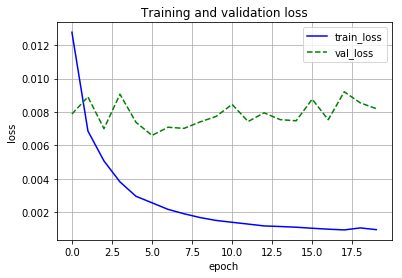

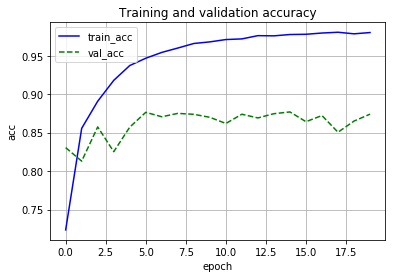

In [10]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from matplotlib import pyplot as plt
from cnn_finetune import make_model

train_dataset = torchvision.datasets.CIFAR10(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data/', train=False, transform=transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=2)

num_classes = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# AlexNetはあまりにも元画像とのサイズ差があるため断念
# ここから転移学習
# AlexNetの概要: https://qiita.com/INM/items/b1decdd6d876d88d80b5
# pretrained=TrueはImageNetにて事前学習済みのモデルを返す
# net = models.alexnet(pretrained=True)
# net = net.to(device)

# for param in net.parameters():
    # backward時にパラメータの更新が行われない  
#    param.requires_grad = False
        
# num_ftrs = net.classifier[6].in_features # 4096
# 最終層のみ新規に上書き（＝パラメータの更新対象となる）
# 当然だが新規に追加した層に関しては学習する必要がある
# net.classifier[6] = nn.Linear(num_ftrs, 2).to(device)    

# children:  
# for x in list(net.children()):
#   print(x, '\n')

## ここまで転移学習

# make_modelメソッドならinput_sizeを柔軟に変更できる
net = make_model('vgg16', num_classes=10, pretrained=True, input_size=(32, 32))
device = torch.device('cuda')
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

num_epochs = 20

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    # train
    net.train()
    for i, (images, labels) in enumerate(train_loader):
        # view()での変換をしない
        images, labels = images.to(device), labels.to(device)
        # 傾配を初期化しているのであって、学習すべき重みパラメータの初期化は当然していない
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    # val
    net.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            # view()での変換をしない
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()

    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)

    print('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}'
          .format(epoch + 1, num_epochs, i + 1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()


In [7]:
pip install cnn_finetune

     |████████████████████████████████| 61kB 23.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/34/b8/11/56725d6a75a9dcc3ac3531d3fcb374de856096cc442de49dd7
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built cnn-finetune pretrainedmodels munch
